In [1]:
import os
import cv2
import numpy as np
import torch
import yaml
from matplotlib import pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from internal.configs.dataset import SemanticColmapParams
from internal.dataparsers.semantic_colmap_dataparser import SemanticColmapDataParser
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.renderers.gsplat_renderer import GSPlatRenderer
from internal.semantic_splatting import SemanticSplatting

In [2]:
dataparser_outputs = SemanticColmapDataParser(
    path=os.path.expanduser("~/data/TanksAndTemples/colmap/Truck/more_accurate/dense_max_1600"),
    output_path=os.getcwd(),
    global_rank=0,
    params=SemanticColmapParams(),
).get_outputs()

appearance group by camera id
loading colmap 3D points
[colmap dataparser] train set images: 251, val set images: 32, loaded mask: 0


In [3]:
load_from = "../outputs/Truck/semantic-gsplat/checkpoints/epoch=40-step=10000.ckpt"
ckpt = torch.load(load_from, map_location="cpu")

ckpt["hyper_parameters"]["initialize_from"] = "../" + ckpt["hyper_parameters"]["initialize_from"]
model = SemanticSplatting(**ckpt["hyper_parameters"])
model.setup("validate")
model.load_state_dict(ckpt["state_dict"])
model.on_load_checkpoint(ckpt)
model = model.to(device="cuda")
model.eval()

gaussian_semantic_features_smoothed = model.get_processed_semantic_features()
with torch.no_grad():
    model.gaussian_semantic_features.copy_(gaussian_semantic_features_smoothed)
gaussian_semantic_features_smoothed = model.gaussian_semantic_features
del model.gaussian_semantic_features
del ckpt
torch.cuda.empty_cache()

smooth_dropout=-1


In [4]:
all_scales = []
for i in dataparser_outputs.train_set:
    all_scales.append(torch.load(i[4][1], map_location=model.device))
all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
upper_bound_scale

63.110721588134766

In [5]:
q_trans = model.get_quantile_func(all_scales, "uniform")

In [6]:
q_trans(torch.Tensor([70]))

tensor([[1.]])

# Begin Segmenting

In [7]:
ref_img_camera_id = 1
camera = dataparser_outputs.train_set.cameras[ref_img_camera_id].to_device(model.device)

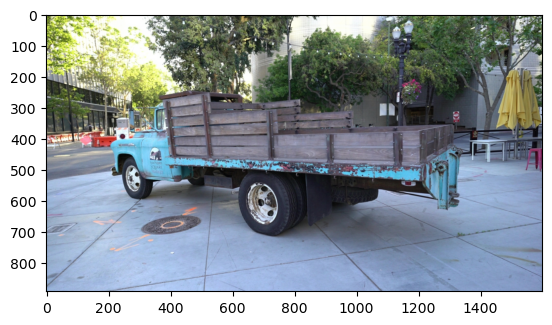

In [8]:
img = cv2.imread(dataparser_outputs.train_set.image_paths[ref_img_camera_id])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [9]:
rendered_features = model.renderer_forward(camera, semantic_features=gaussian_semantic_features_smoothed)["render"]
feature_h, feature_w = rendered_features.shape[-2:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


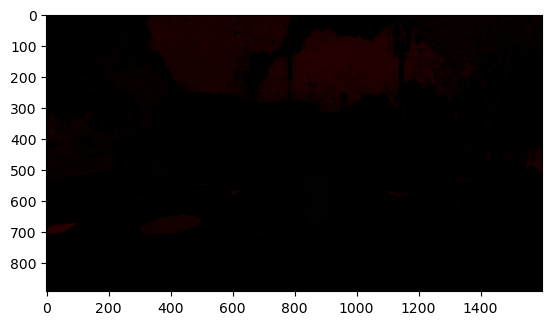

In [10]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.]).cuda()

    gates = model.scale_gate(scale)

    feature_with_scale = rendered_features
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1, 2, 0])

    # scale_conditioned_feature = scale_conditioned_feature / (scale_conditioned_feature.max() + 1e-9)

    plt.imshow((scale_conditioned_feature / scale_conditioned_feature.max())[:, :, :3].detach().cpu().numpy())

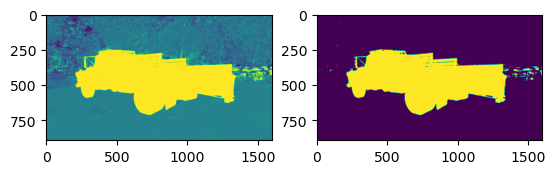

In [11]:
query_index = (400, 300)

query_index = (
    int(query_index[0] / camera.height.item() * camera.height.item()),
    int(query_index[1] / camera.width.item() * camera.width.item()),
)

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim=-1, p=2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1, 2, 1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1, 2, 2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

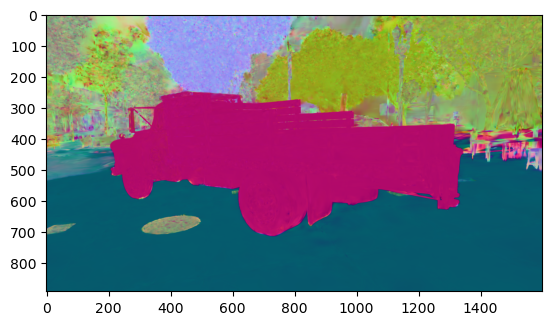

In [12]:
# SHOW PCA in 2D

# CHW -> PCA dimension reduction DHW (D=3)

from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

t = (t - t.min(axis=0)) / (t.max(axis=0) - t.min(axis=0))
t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
plt.imshow(t)

# Cluster in 2D

In [13]:
downsampled_features = torch.nn.functional.interpolate(
    scale_conditioned_feature.permute([2, 0, 1]).unsqueeze(0),
    (128, 128),
    mode='bilinear',
).squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim=0, p=2).permute([1, 2, 0])

In [14]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(
    cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels)) - 1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i - 1] = torch.nn.functional.normalize(cluster_normed_features[labels == i - 1].mean(dim=0), dim=-1)

label_to_color = np.random.rand(200, 3)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [15]:
label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim=-1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

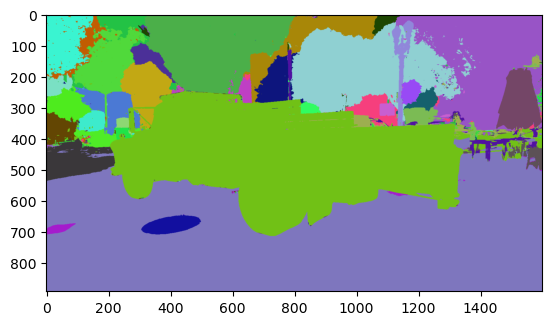

In [16]:
plt.imshow(colored_labels)

# Segmentation in 3D

In [17]:
gaussian_model = model.models.gaussian

In [18]:
point_features = gaussian_semantic_features_smoothed

scale_conditioned_point_features = point_features * gates.unsqueeze(0)

In [19]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim=-1, p=2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.5] = 0

In [20]:
del point_features
del scale_conditioned_point_features
del normed_scale_conditioned_point_features
torch.cuda.empty_cache()

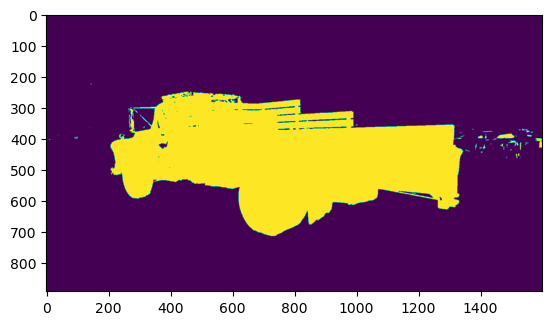

In [21]:
with torch.no_grad():
    plt.imshow((GSPlatRenderer.render(
        means3D=gaussian_model.get_xyz,
        opacities=gaussian_model.get_opacity,
        scales=gaussian_model.get_scaling,
        rotations=gaussian_model.get_rotation,
        features=None,
        active_sh_degree=0,
        viewpoint_camera=camera,
        bg_color=torch.zeros((1,), dtype=torch.float, device=model.device),
        colors_precomp=similarities.unsqueeze(-1),
        anti_aliased=True,
    )["render"].permute([1, 2, 0]) > 0.6).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


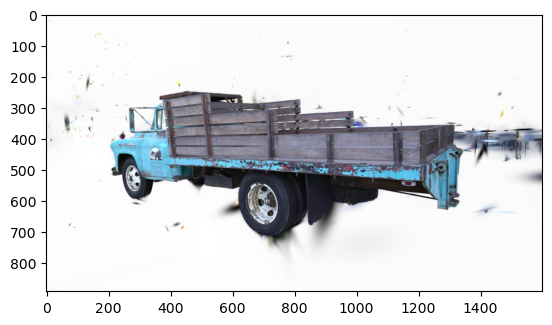

In [22]:
with torch.no_grad():
    opacities = gaussian_model.get_opacity.clone()
    opacities[similarities <= 0.75] = 0.
    plt.imshow((GSPlatRenderer.render(
        means3D=gaussian_model.get_xyz,
        opacities=opacities,
        scales=gaussian_model.get_scaling,
        rotations=gaussian_model.get_rotation,
        features=gaussian_model.get_features,
        active_sh_degree=3,
        viewpoint_camera=dataparser_outputs.train_set.cameras[ref_img_camera_id].to_device(model.device),
        bg_color=torch.ones((3,), dtype=torch.float, device=model.device),
        anti_aliased=True,
    )["render"].permute([1, 2, 0])).cpu())
del opacities

# Cluster in 3D

In [23]:
point_features = gaussian_semantic_features_smoothed

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim=-1, p=2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim=-1, p=2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim=-1, keepdim=True)

print(len(sampled_point_features))

84597


In [24]:
del point_features
del scale_conditioned_point_features
del sampled_point_features
torch.cuda.empty_cache()

In [25]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels)) - 1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i - 1] = torch.nn.functional.normalize(
        normed_sampled_point_features[cluster_labels == i - 1].mean(dim=0), dim=-1)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]


In [26]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [27]:
del cluster_centers
del normed_point_features
torch.cuda.empty_cache()

In [28]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

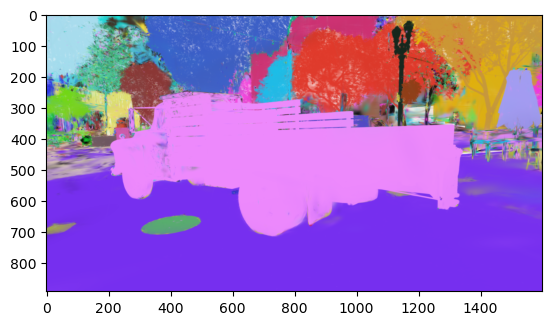

In [29]:
with torch.no_grad():
    plt.imshow((GSPlatRenderer.render(
        means3D=gaussian_model.get_xyz,
        opacities=gaussian_model.get_opacity,
        scales=gaussian_model.get_scaling,
        rotations=gaussian_model.get_rotation,
        features=None,
        active_sh_degree=0,
        viewpoint_camera=dataparser_outputs.train_set.cameras[ref_img_camera_id].to_device(model.device),
        bg_color=torch.ones((3,), dtype=torch.float, device=model.device),
        colors_precomp=torch.tensor(point_colors, dtype=torch.float, device=model.device),
        anti_aliased=True,
    )["render"].permute([1, 2, 0])).cpu())